## 🎯 Expected Goals (xG) Analysis

### Key Research Questions:
- ✅ Which team had the **highest xG** and scored the most goals?
- ✅ Which game had the **highest combined xG** (xG + opp_xG)?
- ✅ Which game had the **biggest difference** between xG and actual goals?
- ✅ Were there any **significant xG trends** or series?
- ✅ How have **average and median xG** changed across seasons?
- ✅ xG comparison **with and without penalties**

### Visualizations:
- 📈 Line plots: xG trends over seasons
- 📊 Bar charts: Teams with biggest xG vs goals difference
- 🔵 Density plot: xG vs actual goals scored
- 📉 Scatter plot: xG overperformance/underperformance

---

In [8]:
import pandas as pd

df = pd.read_parquet('data/serie_a_matches_processed.parquet')

df.tail()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,pkatt,season,team,opp captain,opp sh,opp sot,opp dist,opp fk,opp pk,opp pkatt
1946,2020-09-20,18:00,Serie A,1,Sun,Home,D,1,1,Cagliari,...,0,2020,Sassuolo,João Pedro,8,4,15.9,1,0,0
1947,2020-09-20,15:00,Serie A,1,Sun,Home,W,4,1,Crotone,...,0,2020,Genoa,Alex Cordaz,13,3,18.8,0,0,0
1948,2020-09-20,12:30,Serie A,1,Sun,Home,L,0,2,Napoli,...,0,2020,Parma,Lorenzo Insigne,17,6,19.4,0,0,0
1949,2020-09-19,20:45,Serie A,1,Sat,Home,W,3,0,Roma,...,0,2020,Hellas Verona,Lorenzo Pellegrini,21,4,NaN,0,0,0
1950,2020-09-19,18:00,Serie A,1,Sat,Home,W,1,0,Torino,...,0,2020,Fiorentina,Andrea Belotti,6,3,18.7,1,0,0


## ✅ Implementation (season-based, fully commented)
This section implements every research point above with clear, season-focused analysis and readable visualizations.

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 0) Basic preparation
# -----------------------------
# Make plots readable in notebooks
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 13

# Handle round = 0 (playoffs) by excluding, as requested in earlier notebook
if 'round' in df.columns:
    df = df[df['round'] > 0]

# Exclude season 2025 (still in progress, incomplete data)
df = df[df['season'] != 2025]

# Make sure date is parsed for time series analysis
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Sanity check: how many seasons?
seasons = sorted(df['season'].dropna().unique())
print(f"Seasons available: {seasons}")
print(f"Rows: {len(df):,}")
print(f"Note: Season 2025 excluded (still in progress)")

# Helper: choose a season for focused examples (latest complete season)
season_focus = seasons[-1]
print(f"Using season_focus = {season_focus}")

Seasons available: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Rows: 1,900
Note: Season 2025 excluded (still in progress)
Using season_focus = 2024


### 1️⃣ Which team had the highest xG and scored the most goals?

Top xG team per season:
    season            team  xg_total  goals_total
0     2020        Atalanta      74.5           90
27    2021  Internazionale      81.4           84
46    2022  Internazionale      68.2           71
68    2023  Internazionale      78.1           89
88    2024  Internazionale      66.9           79

Top goals team per season:
    season            team  goals_total  xg_total
0     2020        Atalanta           90      74.5
27    2021  Internazionale           84      81.4
52    2022          Napoli           77      64.7
68    2023  Internazionale           89      78.1
88    2024  Internazionale           79      66.9


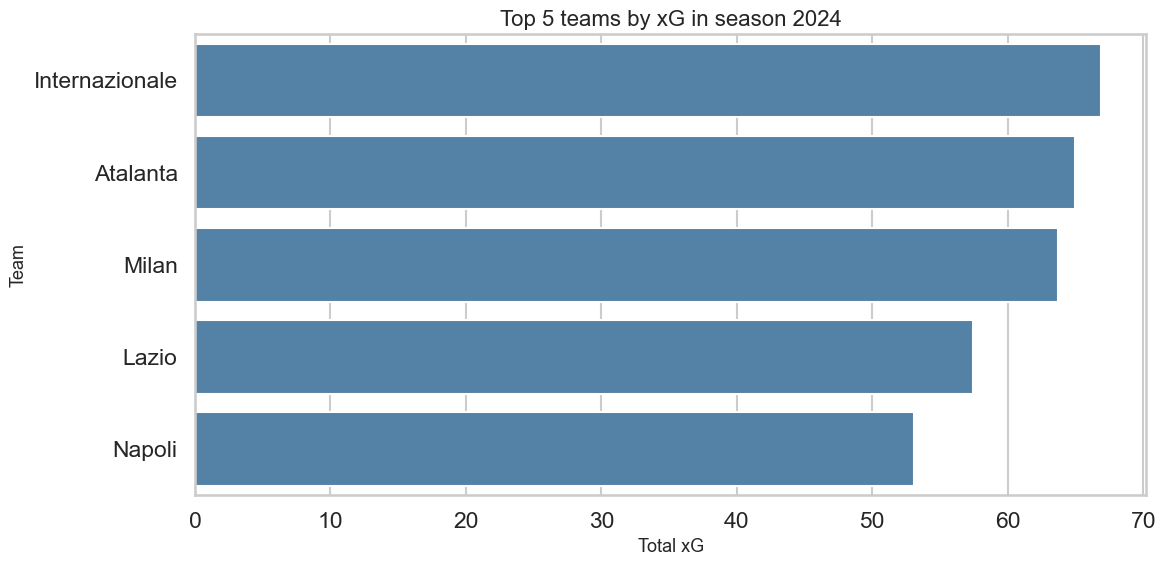

In [14]:
# Approach: aggregate by season and team, accounting for both home and away matches
# Since each row represents one match from home perspective:
# - When team is 'home': use xg, gf, sh, sot, etc.
# - When team is 'away' (opponent): use xga, ga, opp sh, opp sot, etc.

# Home matches aggregation
home_stats = (
    df.groupby(['season', 'team'], as_index=False)
      .agg(
          xg_home=('xg', 'sum'),
          goals_home=('gf', 'sum'),
          matches_home=('team', 'count')
      )
)

# Away matches aggregation (when team is the opponent)
away_stats = (
    df.groupby(['season', 'opponent'], as_index=False)
      .agg(
          xg_away=('xga', 'sum'),
          goals_away=('ga', 'sum'),
          matches_away=('opponent', 'count')
      )
      .rename(columns={'opponent': 'team'})
)

# Combine home and away stats
team_season = home_stats.merge(away_stats, on=['season', 'team'], how='outer').fillna(0)
team_season['xg_total'] = team_season['xg_home'] + team_season['xg_away']
team_season['goals_total'] = team_season['goals_home'] + team_season['goals_away']
team_season['matches'] = team_season['matches_home'] + team_season['matches_away']

# Keep only essential columns
team_season = team_season[['season', 'team', 'xg_total', 'goals_total', 'matches']]

# Top xG team per season
top_xg_by_season = (
    team_season.sort_values(['season', 'xg_total'], ascending=[True, False])
               .groupby('season')
               .head(1)
)

# Top goals team per season
top_goals_by_season = (
    team_season.sort_values(['season', 'goals_total'], ascending=[True, False])
               .groupby('season')
               .head(1)
)

print("Top xG team per season:")
print(top_xg_by_season[['season', 'team', 'xg_total', 'goals_total']])

print("\nTop goals team per season:")
print(top_goals_by_season[['season', 'team', 'goals_total', 'xg_total']])

# Visualization: Top 5 teams by xG for the selected season
season_top5_xg = (
    team_season[team_season['season'] == season_focus]
    .sort_values('xg_total', ascending=False)
    .head(5)
)

plt.figure(figsize=(12, 6))
sns.barplot(data=season_top5_xg, x='xg_total', y='team', color='steelblue')
plt.title(f"Top 5 teams by xG in season {season_focus}")
plt.xlabel("Total xG")
plt.ylabel("Team")
plt.tight_layout()
plt.show()

In [ ]:
season_summary = (
    team_season.sort_values(['xg_total'], ascending=[False])
               .groupby('season')
               .head(5)
)

print("Top 5 Highest xG per season in the last 5 years")
print(season_summary[['season', 'team', 'xg_total', 'goals_total', 'matches']])

Top 5 Highest xG per season in the last 5 years
    season            team  xg_total  goals_total  matches
27    2021  Internazionale      81.4           84       38
68    2023  Internazionale      78.1           89       38
0     2020        Atalanta      74.5           90       38
9     2020        Juventus      74.3           77       38
8     2020  Internazionale      74.2           89       38
11    2020           Milan      70.7           74       38
46    2022  Internazionale      68.2           71       38
12    2020          Napoli      67.8           86       38
88    2024  Internazionale      66.9           79       38
72    2023           Milan      66.2           76       38
32    2021            Roma      65.2           59       38
80    2024        Atalanta      65.0           78       38
52    2022          Napoli      64.7           77       38
92    2024           Milan      63.7           61       38
20    2021        Atalanta      62.3           65       38
74    20

### Overperforming xG (2024 season)

/var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/ipykernel_44236/1756381325.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=season_top_over, x='overperf', y='team',
/var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/ipykernel_44236/1756381325.py:11: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(data=season_top_over, x='overperf', y='team',


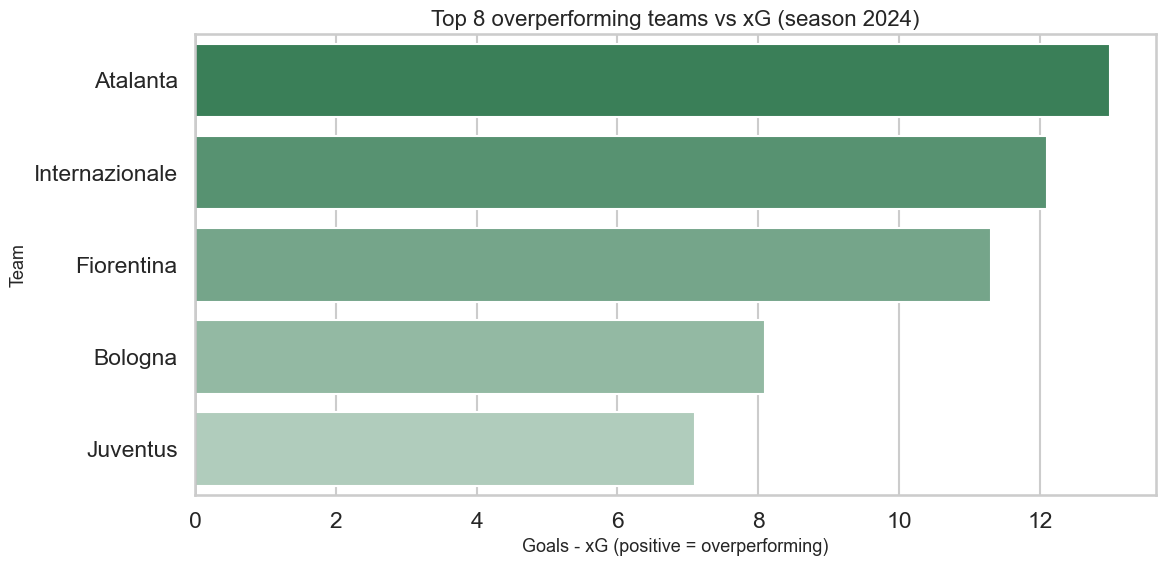


Top overperformers in season 2024:
              team  goals_total  xg_total  overperf
80        Atalanta           78      65.0      13.0
88  Internazionale           79      66.9      12.1
85      Fiorentina           60      48.7      11.3
81         Bologna           57      48.9       8.1
89        Juventus           58      50.9       7.1


In [42]:
team_overperf = team_season.copy()
team_overperf['overperf'] = team_overperf['goals_total'] - team_overperf['xg_total']

season_top_over = (
    team_overperf[team_overperf['season'] == season_focus]
    .sort_values('overperf', ascending=False)
    .head(5)
)

plt.figure(figsize=(12, 6))
sns.barplot(data=season_top_over, x='overperf', y='team', 
            palette=sns.light_palette('seagreen', n_colors=7, reverse=True))
plt.title(f"Top 8 overperforming teams vs xG (season {season_focus})")
plt.xlabel("Goals - xG (positive = overperforming)")
plt.ylabel("Team")
plt.axvline(0, color='black', linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

print(f"\nTop overperformers in season {season_focus}:")
print(season_top_over[['team', 'goals_total', 'xg_total', 'overperf']])

/var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/ipykernel_44236/3659919936.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=season_top_under, x='underperf', y='team',
/var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/ipykernel_44236/3659919936.py:13: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(data=season_top_under, x='underperf', y='team',


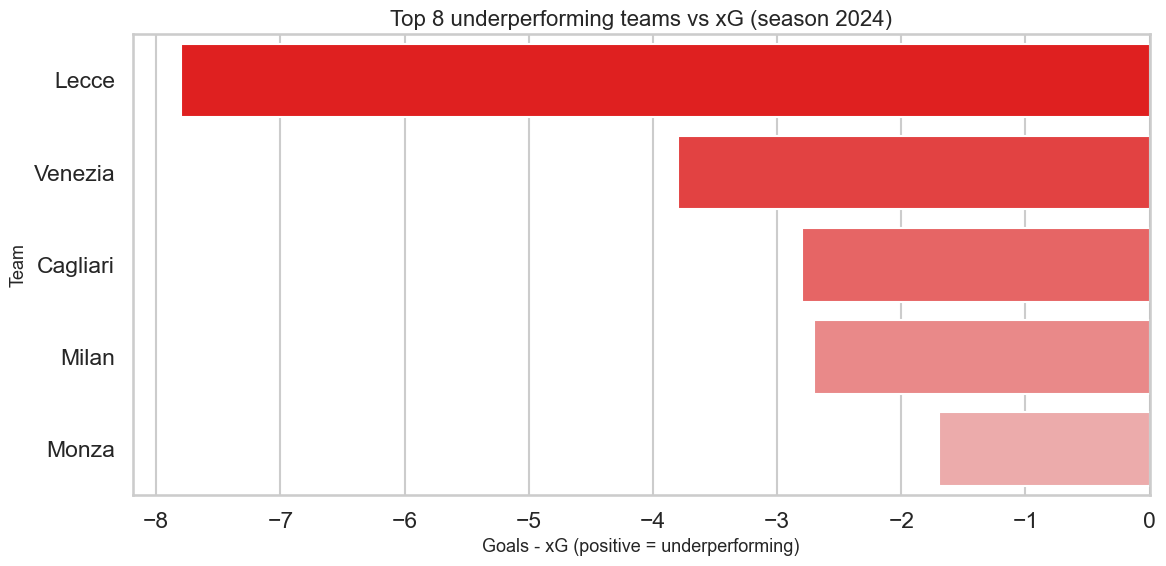


Top underperformers in season 2024:
        team  goals_total  xg_total  underperf
91     Lecce           27      34.8       -7.8
99   Venezia           32      35.8       -3.8
82  Cagliari           40      42.8       -2.8
92     Milan           61      63.7       -2.7
93     Monza           28      29.7       -1.7


In [41]:
# underperforming xG

team_underperf = team_season.copy()
team_underperf['underperf'] = team_underperf['goals_total'] - team_underperf['xg_total']

season_top_under = (
    team_underperf[team_underperf['season'] == season_focus]
			.sort_values('underperf', ascending=True)
    	.head(5)
)

plt.figure(figsize=(12, 6))
sns.barplot(data=season_top_under, x='underperf', y='team', 
            palette=sns.light_palette('red', n_colors=7, reverse=True))
plt.title(f"Top 8 underperforming teams vs xG (season {season_focus})")
plt.xlabel("Goals - xG (positive = underperforming)")
plt.ylabel("Team")
plt.axvline(0, color='black', linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

print(f"\nTop underperformers in season {season_focus}:")
print(season_top_under[['team', 'goals_total', 'xg_total', 'underperf']])

### 8️⃣ Over/underperformance scatter plot

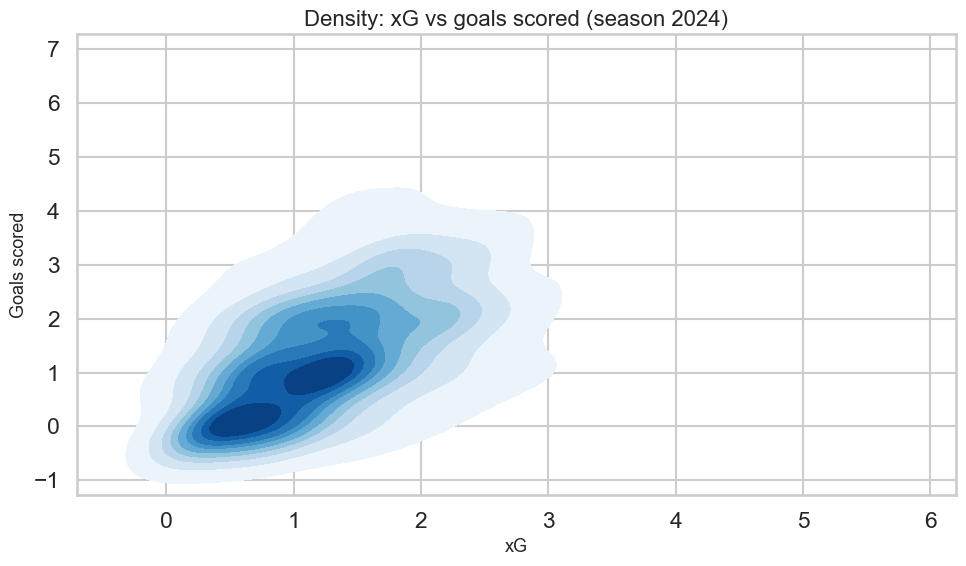

In [25]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df[df['season'] == season_focus],
    x='xg',
    y='gf',
    fill=True,
    cmap='Blues',
    thresh=0.05,
    levels=10
)
plt.title(f"Density: xG vs goals scored (season {season_focus})")
plt.xlabel("xG")
plt.ylabel("Goals scored")
plt.tight_layout()
plt.show()

### 6️⃣ xG with and without penalties

### 5️⃣ How have average and median xG changed across seasons?

### 4️⃣ Were there any significant xG trends or series?

### 3️⃣ Which game had the biggest difference between xG and actual goals?

### 2️⃣ Which game had the highest combined xG?

### 🏆 Average xG vs Final Table Position

In [57]:
from helpers.season_table import load_season_tables

season_tables = load_season_tables()

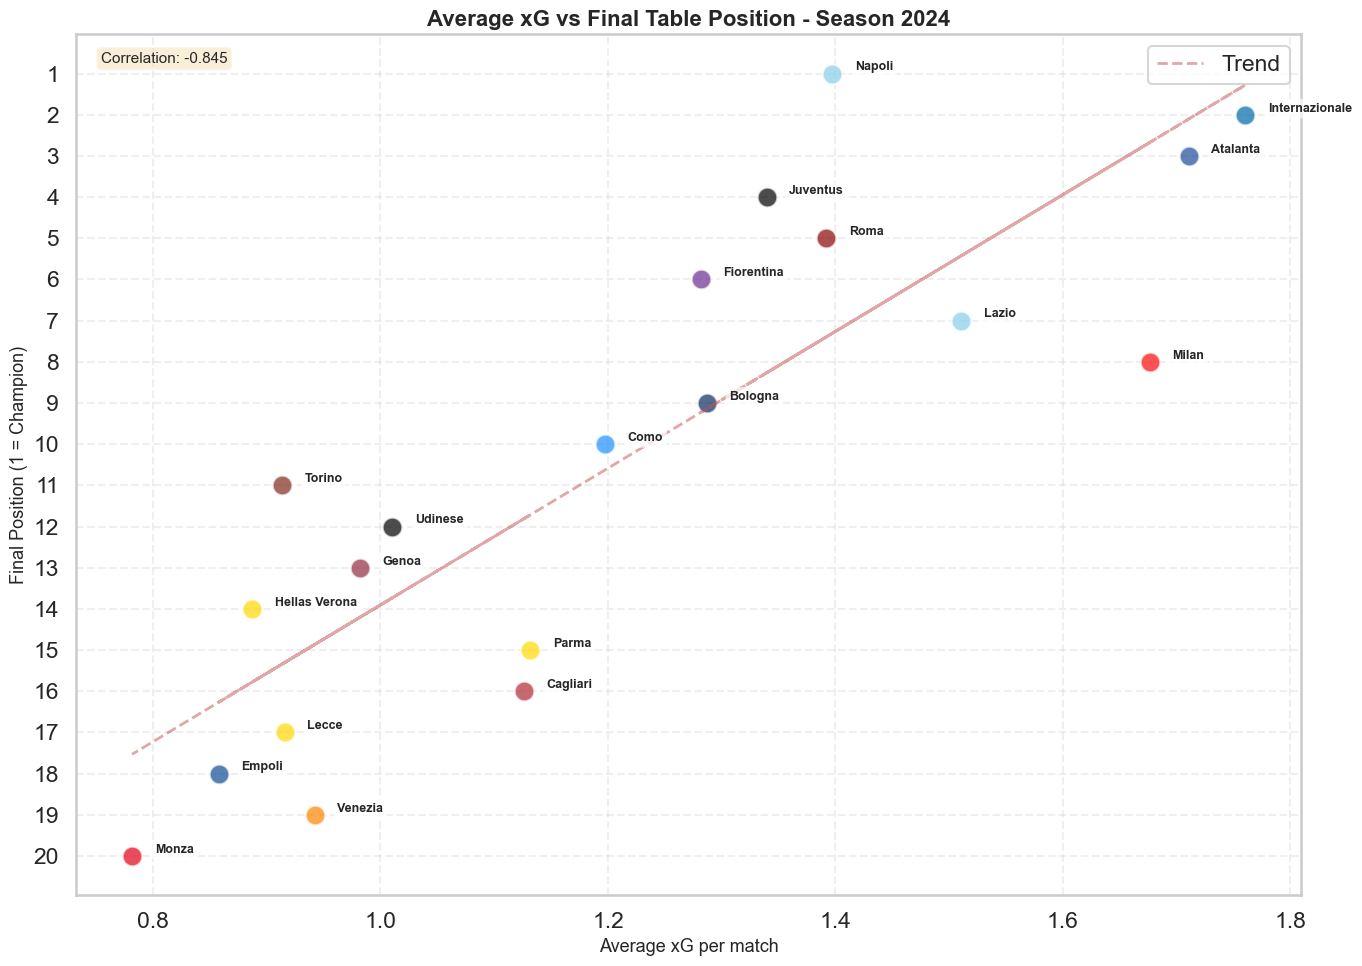


Correlation between avg xG and final position: -0.845
(Negative correlation = higher xG leads to better position)


In [63]:
# Visualization with team crests
# Note: This creates a scatter plot for a specific season with team names as labels
# For actual team crests, you would need team logo images

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# Define team colors (primary club colors)
team_colors = {
    'Napoli': '#87CEEB',           # Sky blue
    'Internazionale': '#0068A8',   # Inter blue
    'Atalanta': '#1E4A99',         # Atalanta blue
    'Juventus': '#000000',         # Black
    'Roma': '#8B0304',             # Roma red
    'Lazio': '#87CEEB',            # Sky blue
    'Milan': '#FB090B',            # Rossonero red
    'Fiorentina': '#6B2C91',       # Viola purple
    'Bologna': '#0A2A5E',          # Bologna blue
    'Torino': '#7F2A1E',           # Granata maroon
    'Como': '#1E90FF',             # Blue
    'Udinese': '#000000',          # Black
    'Genoa': '#922B3C',            # Genoa red
    'Hellas Verona': '#FFD700',    # Yellow
    'Parma': '#FFDB00',            # Yellow
    'Cagliari': '#B02A35',         # Cagliari red
    'Lecce': '#FFD700',            # Yellow
    'Empoli': '#0E4C92',           # Blue
    'Venezia': '#FF8300',          # Orange
    'Monza': '#E2001A',            # Red
    'Sassuolo': '#009B4D',         # Green
    'Sampdoria': '#003C7F',        # Blucerchiato blue
    'Salernitana': '#8B0000',      # Dark red
    'Spezia': '#000000',           # Black
    'Crotone': '#0033A0',          # Blue
    'Benevento': '#FFD700',        # Yellow
    'Spal': '#1E4A99',             # Blue
}

# Select a season to visualize
viz_season = season_focus

# Get data for selected season
season_viz = season_tables[viz_season][38].copy()

# season_viz = position_vs_xg[position_vs_xg['season'] == viz_season].copy()

# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Plot points with team names as labels
for _, row in season_viz.iterrows():
    # Get team color, default to steelblue if not found
    team_color = team_colors.get(row['team'], 'steelblue')
    
    ax.scatter(row['xg_for'] / 38.0, row['pos'], s=200, alpha=0.7, color=team_color, 
               zorder=2, edgecolors='white', linewidths=1.5)
    # Offset text to the right and slightly up for better visibility
    ax.text(row['xg_for'] / 38.0 + 0.02, row['pos'] - 0.15, row['team'], 
            fontsize=9, ha='left', va='center', weight='bold', zorder=3,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.7))

# Invert y-axis so position 1 is at the top
ax.invert_yaxis()

# Set Y-axis to show integer values from 1 to 20
ax.set_yticks(range(1, 21))

# Add grid and labels
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlabel('Average xG per match', fontsize=13)
ax.set_ylabel('Final Position (1 = Champion)', fontsize=13)
ax.set_title(f'Average xG vs Final Table Position - Season {viz_season}', fontsize=16, weight='bold')

# Add trend line
z = np.polyfit(season_viz['xg_for'] / 38.0, season_viz['pos'], 1)
p = np.poly1d(z)
ax.plot(season_viz['xg_for'] / 38.0, p(season_viz['xg_for'] / 38.0), "r--", alpha=0.5, linewidth=2, label='Trend')

# Add correlation coefficient
corr = season_viz['xg_for'].corr(season_viz['pos'])
ax.text(0.02, 0.98, f'Correlation: {corr:.3f}', 
        transform=ax.transAxes, fontsize=11, va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.legend()
plt.tight_layout()
plt.show()

print(f"\nCorrelation between avg xG and final position: {corr:.3f}")
print("(Negative correlation = higher xG leads to better position)")

### 🏠🛫 Home vs Away xG Distribution (Histogram)

📊 xG Distribution Only:


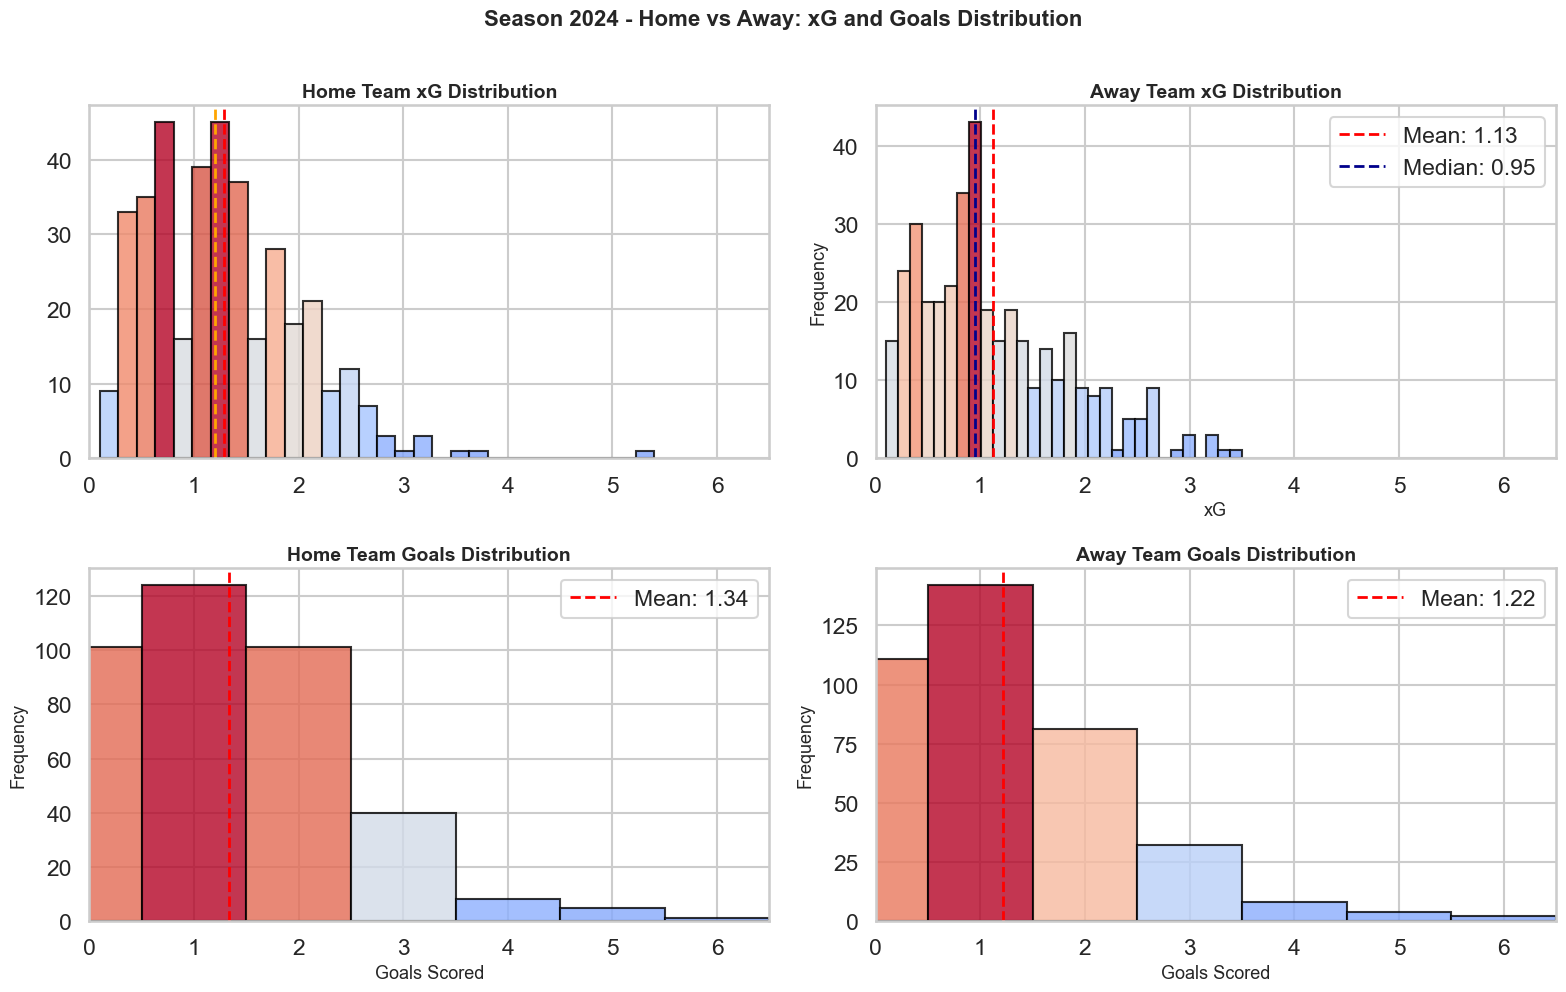


Season 2024 - Summary Statistics

Home Team xG:
  Mean:   1.284
  Median: 1.200
  Std:    0.718

Away Team xG:
  Mean:   1.126
  Median: 0.950
  Std:    0.705

Home Team Goals:
  Mean:   1.339
  Median: 1.000

Away Team Goals:
  Mean:   1.221
  Median: 1.000

Home Advantage (xG difference): 0.159
Home Advantage (goals difference): 0.118



In [84]:
def plot_home_away_distribution(season, show_goals=False):
    """
    Plot xG distribution for home and away teams for a given season.
    
    Parameters:
    -----------
    season : int
        The season to analyze (e.g., 2024)
    show_goals : bool
        If True, also show goals distribution alongside xG
    """
    season_df = df[df['season'] == season].copy()
    
    if show_goals:
        # Create 2x2 subplot: xG and goals for home and away
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        
        # Calculate common x-axis limits for each column
        home_max = max(season_df['xg'].max(), season_df['gf'].max())
        away_max = max(season_df['xga'].max(), season_df['ga'].max())
        
        # Home xG distribution with gradient
        n, bins, patches = axes[0, 0].hist(season_df['xg'], bins=30, alpha=0.8, edgecolor='black')
        # Color bars with gradient (cooler to warmer based on frequency)
        cmap_home_xg = plt.cm.coolwarm
        max_freq = max(n)
        for count, patch in zip(n, patches):
            patch.set_facecolor(cmap_home_xg(0.2 + 0.8 * count / max_freq))
        axes[0, 0].axvline(season_df['xg'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {season_df["xg"].mean():.2f}')
        axes[0, 0].axvline(season_df['xg'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {season_df["xg"].median():.2f}')
        axes[0, 0].set_title('Home Team xG Distribution', fontsize=14, weight='bold')
        axes[0, 0].set_xlim(0, home_max + 0.5)
        
        # Away xG distribution with gradient
        n, bins, patches = axes[0, 1].hist(season_df['xga'], bins=30, alpha=0.8, edgecolor='black')
        # Color bars with gradient (cooler to warmer based on frequency)
        cmap_away_xg = plt.cm.coolwarm
        max_freq = max(n)
        for count, patch in zip(n, patches):
            patch.set_facecolor(cmap_away_xg(0.2 + 0.8 * count / max_freq))
        axes[0, 1].axvline(season_df['xga'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {season_df["xga"].mean():.2f}')
        axes[0, 1].axvline(season_df['xga'].median(), color='darkblue', linestyle='--', linewidth=2, label=f'Median: {season_df["xga"].median():.2f}')
        axes[0, 1].set_title('Away Team xG Distribution', fontsize=14, weight='bold')
        axes[0, 1].set_xlabel('xG')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].set_xlim(0, away_max + 0.5)
        
        n, bins, patches = axes[1, 0].hist(season_df['gf'], bins=np.arange(-0.5, int(season_df['gf'].max()) + 1.5, 1.0), alpha=0.8, edgecolor='black')
        cmap_home_goals = plt.cm.coolwarm
        max_freq = max(n)
        for count, patch in zip(n, patches):
            patch.set_facecolor(cmap_home_goals(0.2 + 0.8 * count / max_freq))
        axes[1, 0].axvline(season_df['gf'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {season_df["gf"].mean():.2f}')
        axes[1, 0].set_title('Home Team Goals Distribution', fontsize=14, weight='bold')
        axes[1, 0].set_xlabel('Goals Scored')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        axes[1, 0].set_xlim(0, home_max + 0.5)
        
        n, bins, patches = axes[1, 1].hist(season_df['ga'], bins=np.arange(-0.5, int(season_df['ga'].max()) + 1.5, 1.0), alpha=0.8, edgecolor='black')
        cmap_away_goals = plt.cm.coolwarm
        max_freq = max(n)
        for count, patch in zip(n, patches):
            patch.set_facecolor(cmap_away_goals(0.2 + 0.8 * count / max_freq))
        axes[1, 1].axvline(season_df['ga'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {season_df["ga"].mean():.2f}')
        axes[1, 1].set_title('Away Team Goals Distribution', fontsize=14, weight='bold')
        axes[1, 1].set_xlabel('Goals Scored')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()
        axes[1, 1].set_xlim(0, away_max + 0.5)
        
        plt.suptitle(f'Season {season} - Home vs Away: xG and Goals Distribution', fontsize=16, weight='bold', y=1.00)
        
    else:
        # Create side-by-side comparison for xG only
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Home xG distribution with gradient (cooler to warmer based on frequency)
        n, bins, patches = axes[0].hist(season_df['xg'], bins=30, alpha=0.8, edgecolor='black')
        cmap_home = plt.cm.coolwarm
        max_freq = max(n)
        for count, patch in zip(n, patches):
            patch.set_facecolor(cmap_home(0.2 + 0.8 * count / max_freq))
        axes[0].axvline(season_df['xg'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {season_df["xg"].mean():.2f}')
        axes[0].axvline(season_df['xg'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {season_df["xg"].median():.2f}')
        axes[0].set_title('Home Team xG Distribution', fontsize=14, weight='bold')
        axes[0].set_xlabel('xG')
        axes[0].set_ylabel('Frequency')
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        
        # Away xG distribution with gradient (cooler to warmer based on frequency)
        n, bins, patches = axes[1].hist(season_df['xga'], bins=30, alpha=0.8, edgecolor='black')
        cmap_away = plt.cm.coolwarm
        max_freq = max(n)
        for count, patch in zip(n, patches):
            patch.set_facecolor(cmap_away(0.2 + 0.8 * count / max_freq))
        axes[1].axvline(season_df['xga'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {season_df["xga"].mean():.2f}')
        axes[1].axvline(season_df['xga'].median(), color='darkblue', linestyle='--', linewidth=2, label=f'Median: {season_df["xga"].median():.2f}')
        axes[1].set_title('Away Team xG Distribution', fontsize=14, weight='bold')
        axes[1].set_xlabel('xG')
        axes[1].set_ylabel('Frequency')
        axes[1].legend()
        axes[1].grid(alpha=0.3)
        
        plt.suptitle(f'Season {season} - Home vs Away xG Distribution', fontsize=16, weight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"Season {season} - Summary Statistics")
    print(f"{'='*60}")
    print(f"\nHome Team xG:")
    print(f"  Mean:   {season_df['xg'].mean():.3f}")
    print(f"  Median: {season_df['xg'].median():.3f}")
    print(f"  Std:    {season_df['xg'].std():.3f}")
    
    print(f"\nAway Team xG:")
    print(f"  Mean:   {season_df['xga'].mean():.3f}")
    print(f"  Median: {season_df['xga'].median():.3f}")
    print(f"  Std:    {season_df['xga'].std():.3f}")
    
    if show_goals:
        print(f"\nHome Team Goals:")
        print(f"  Mean:   {season_df['gf'].mean():.3f}")
        print(f"  Median: {season_df['gf'].median():.3f}")
        
        print(f"\nAway Team Goals:")
        print(f"  Mean:   {season_df['ga'].mean():.3f}")
        print(f"  Median: {season_df['ga'].median():.3f}")
    
    print(f"\nHome Advantage (xG difference): {season_df['xg'].mean() - season_df['xga'].mean():.3f}")
    if show_goals:
        print(f"Home Advantage (goals difference): {season_df['gf'].mean() - season_df['ga'].mean():.3f}")
    print(f"{'='*60}\n")


# Example usage - xG only
print("📊 xG Distribution Only:")

plot_home_away_distribution(season=season_focus, show_goals=True)

## 🎯 Advanced Analysis: Top 3 Deep-Dive Insights

### 🥇 Analysis #1: xG Overperformance Sustainability
### 🥈 Analysis #2: Home Advantage Evolution 
### 🥉 Analysis #3: Round-by-Round Performance Patterns

### 🥇 Analysis #1: xG Overperformance Sustainability

**Question**: Can teams sustain overperformance (scoring more than xG), or does it regress to the mean?

This analysis tracks cumulative (Goals - xG) throughout each season to identify:
- Lucky runs that fade
- Genuinely clinical teams
- Regression patterns

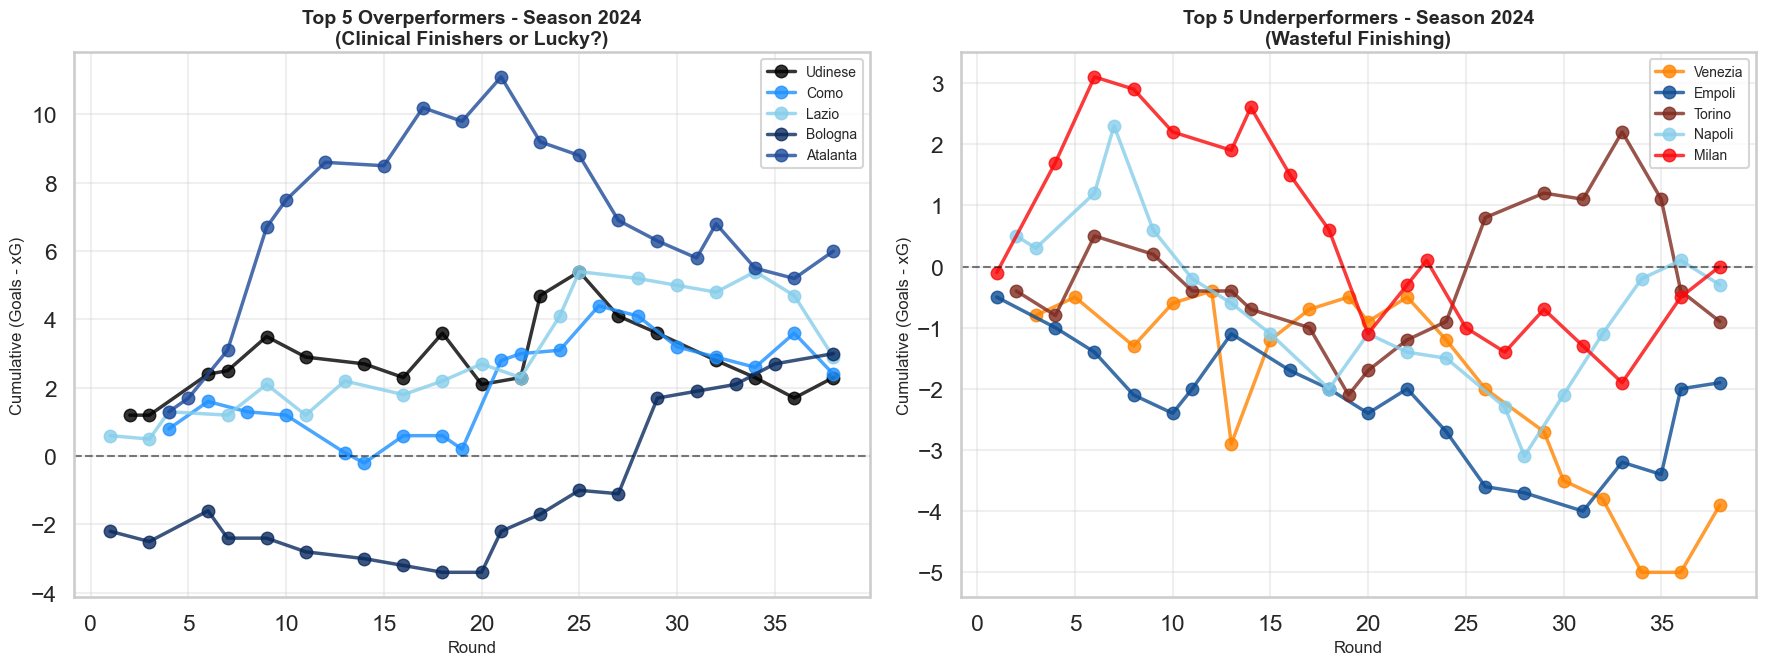


Season 2024 - Overperformance Analysis

Top 5 Clinical Finishers (Most overperformance):
    team  cumulative_overperf
 Udinese                  2.3
    Como                  2.4
   Lazio                  2.9
 Bologna                  3.0
Atalanta                  6.0

Top 5 Wasteful Teams (Most underperformance):
   team  cumulative_overperf
Venezia        -3.900000e+00
 Empoli        -1.900000e+00
 Torino        -9.000000e-01
 Napoli        -3.000000e-01
  Milan        -8.881784e-16



In [85]:
# Analysis #1: xG Overperformance Sustainability
# Track cumulative (Goals - xG) across rounds to see if teams sustain overperformance

# Calculate overperformance per match
df['overperf_match'] = df['gf'] - df['xg']

# For focused season, calculate cumulative overperformance by team
season_df = df[df['season'] == season_focus].sort_values(['team', 'round']).copy()

# Calculate cumulative overperformance
cumulative_overperf = []
for team in season_df['team'].unique():
    team_data = season_df[season_df['team'] == team].copy()
    team_data['cumulative_overperf'] = team_data['overperf_match'].cumsum()
    cumulative_overperf.append(team_data[['team', 'round', 'cumulative_overperf']])

cumulative_df = pd.concat(cumulative_overperf)

# Identify top 5 overperformers and bottom 5 underperformers at season end
final_overperf = cumulative_df[cumulative_df['round'] == 38].sort_values('cumulative_overperf')
top5_teams = final_overperf.tail(5)['team'].tolist()
bottom5_teams = final_overperf.head(5)['team'].tolist()

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot top 5 overperformers
for team in top5_teams:
    team_data = cumulative_df[cumulative_df['team'] == team]
    team_color = team_colors.get(team, 'steelblue')
    ax1.plot(team_data['round'], team_data['cumulative_overperf'], 
             marker='o', linewidth=2.5, alpha=0.8, label=team, color=team_color)

ax1.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax1.set_xlabel('Round', fontsize=12)
ax1.set_ylabel('Cumulative (Goals - xG)', fontsize=12)
ax1.set_title(f'Top 5 Overperformers - Season {season_focus}\n(Clinical Finishers or Lucky?)', 
              fontsize=14, weight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(alpha=0.3)

# Plot bottom 5 underperformers
for team in bottom5_teams:
    team_data = cumulative_df[cumulative_df['team'] == team]
    team_color = team_colors.get(team, 'crimson')
    ax2.plot(team_data['round'], team_data['cumulative_overperf'], 
             marker='o', linewidth=2.5, alpha=0.8, label=team, color=team_color)

ax2.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax2.set_xlabel('Round', fontsize=12)
ax2.set_ylabel('Cumulative (Goals - xG)', fontsize=12)
ax2.set_title(f'Top 5 Underperformers - Season {season_focus}\n(Wasteful Finishing)', 
              fontsize=14, weight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print insights
print(f"\n{'='*70}")
print(f"Season {season_focus} - Overperformance Analysis")
print(f"{'='*70}\n")
print("Top 5 Clinical Finishers (Most overperformance):")
print(final_overperf.tail(5)[['team', 'cumulative_overperf']].to_string(index=False))
print("\nTop 5 Wasteful Teams (Most underperformance):")
print(final_overperf.head(5)[['team', 'cumulative_overperf']].to_string(index=False))
print(f"\n{'='*70}")

### 🥈 Analysis #2: Home Advantage Evolution Heatmap

**Question**: How has home advantage changed across teams and seasons? Did COVID (empty stadiums) affect it?

This heatmap shows home xG advantage by team across seasons:
- Seasons 2020-2021 likely had reduced attendance due to COVID
- Identifies teams most affected by home support

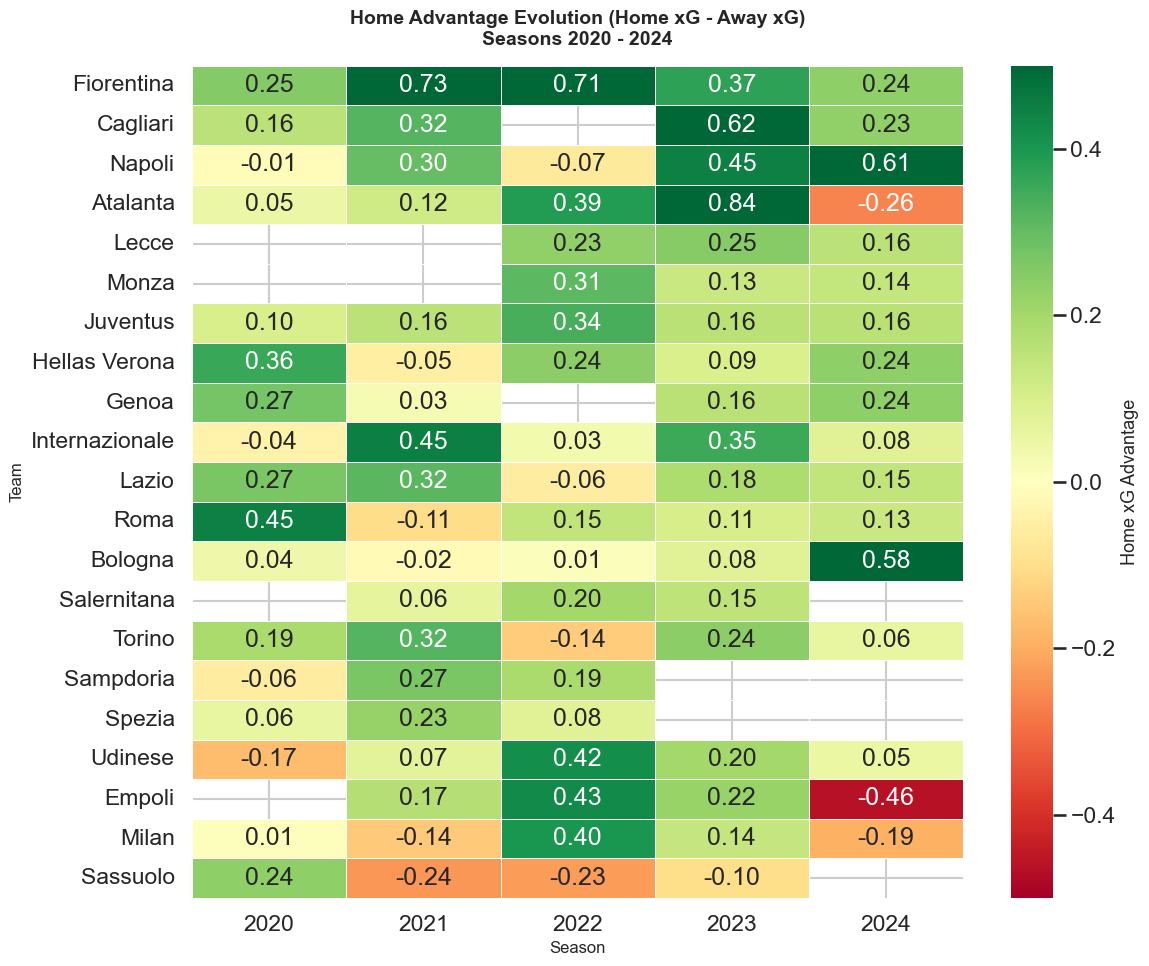


Home Advantage Analysis Across Seasons

Average home advantage by season (all teams):
  2020: +0.133 xG
  2021: +0.176 xG
  2022: +0.180 xG
  2023: +0.237 xG
  2024: +0.159 xG

Teams with strongest home advantage (average across all seasons):
  Fiorentina: +0.459 xG
  Venezia: +0.424 xG
  Parma: +0.350 xG
  Cagliari: +0.333 xG
  Como: +0.300 xG

Teams with weakest home advantage (perform better away):
  Sassuolo: -0.082 xG
  Cremonese: -0.026 xG
  Crotone: -0.016 xG
  Milan: +0.041 xG
  Frosinone: +0.084 xG



In [86]:
# Analysis #2: Home Advantage Evolution Heatmap
# Calculate home xG advantage (Home xG - Away xG) for each team across seasons

# Calculate home advantage per team per season
home_advantage_data = []

for season in seasons:
    season_data = df[df['season'] == season]
    
    for team in season_data['team'].unique():
        # Home matches
        home_matches = season_data[season_data['team'] == team]
        home_xg = home_matches['xg'].mean()
        
        # Away matches (when this team is the opponent)
        away_matches = season_data[season_data['opponent'] == team]
        away_xg = away_matches['xga'].mean()
        
        home_advantage = home_xg - away_xg
        
        home_advantage_data.append({
            'season': season,
            'team': team,
            'home_advantage': home_advantage,
            'home_xg': home_xg,
            'away_xg': away_xg
        })

home_adv_df = pd.DataFrame(home_advantage_data)

# Create pivot table for heatmap (teams that played in at least 3 seasons)
team_counts = home_adv_df['team'].value_counts()
consistent_teams = team_counts[team_counts >= 3].index.tolist()

heatmap_data = home_adv_df[home_adv_df['team'].isin(consistent_teams)].pivot(
    index='team', 
    columns='season', 
    values='home_advantage'
)

# Sort teams by average home advantage
heatmap_data['avg'] = heatmap_data.mean(axis=1)
heatmap_data = heatmap_data.sort_values('avg', ascending=False).drop('avg', axis=1)

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, 
            cmap='RdYlGn', 
            center=0, 
            annot=True, 
            fmt='.2f', 
            cbar_kws={'label': 'Home xG Advantage'},
            linewidths=0.5,
            vmin=-0.5,
            vmax=0.5)

plt.title(f'Home Advantage Evolution (Home xG - Away xG)\nSeasons {min(seasons)} - {max(seasons)}', 
          fontsize=14, weight='bold', pad=15)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Team', fontsize=12)
plt.tight_layout()
plt.show()

# Statistical insights
print(f"\n{'='*70}")
print(f"Home Advantage Analysis Across Seasons")
print(f"{'='*70}\n")
print("Average home advantage by season (all teams):")
season_avg = home_adv_df.groupby('season')['home_advantage'].mean()
for season, avg in season_avg.items():
    print(f"  {season}: {avg:+.3f} xG")

print("\nTeams with strongest home advantage (average across all seasons):")
top_home = home_adv_df.groupby('team')['home_advantage'].mean().sort_values(ascending=False).head(5)
for team, adv in top_home.items():
    print(f"  {team}: {adv:+.3f} xG")
    
print("\nTeams with weakest home advantage (perform better away):")
bottom_home = home_adv_df.groupby('team')['home_advantage'].mean().sort_values().head(5)
for team, adv in bottom_home.items():
    print(f"  {team}: {adv:+.3f} xG")
print(f"\n{'='*70}")

### 🥉 Analysis #3: Round-by-Round Performance Heatmap

**Question**: When do teams peak or slump during the season?

This heatmap visualizes xG performance across all 38 rounds:
- Identifies "Christmas period" effects (rounds 15-20)
- Shows end-of-season collapses or surges
- Reveals tactical/fitness patterns throughout the season

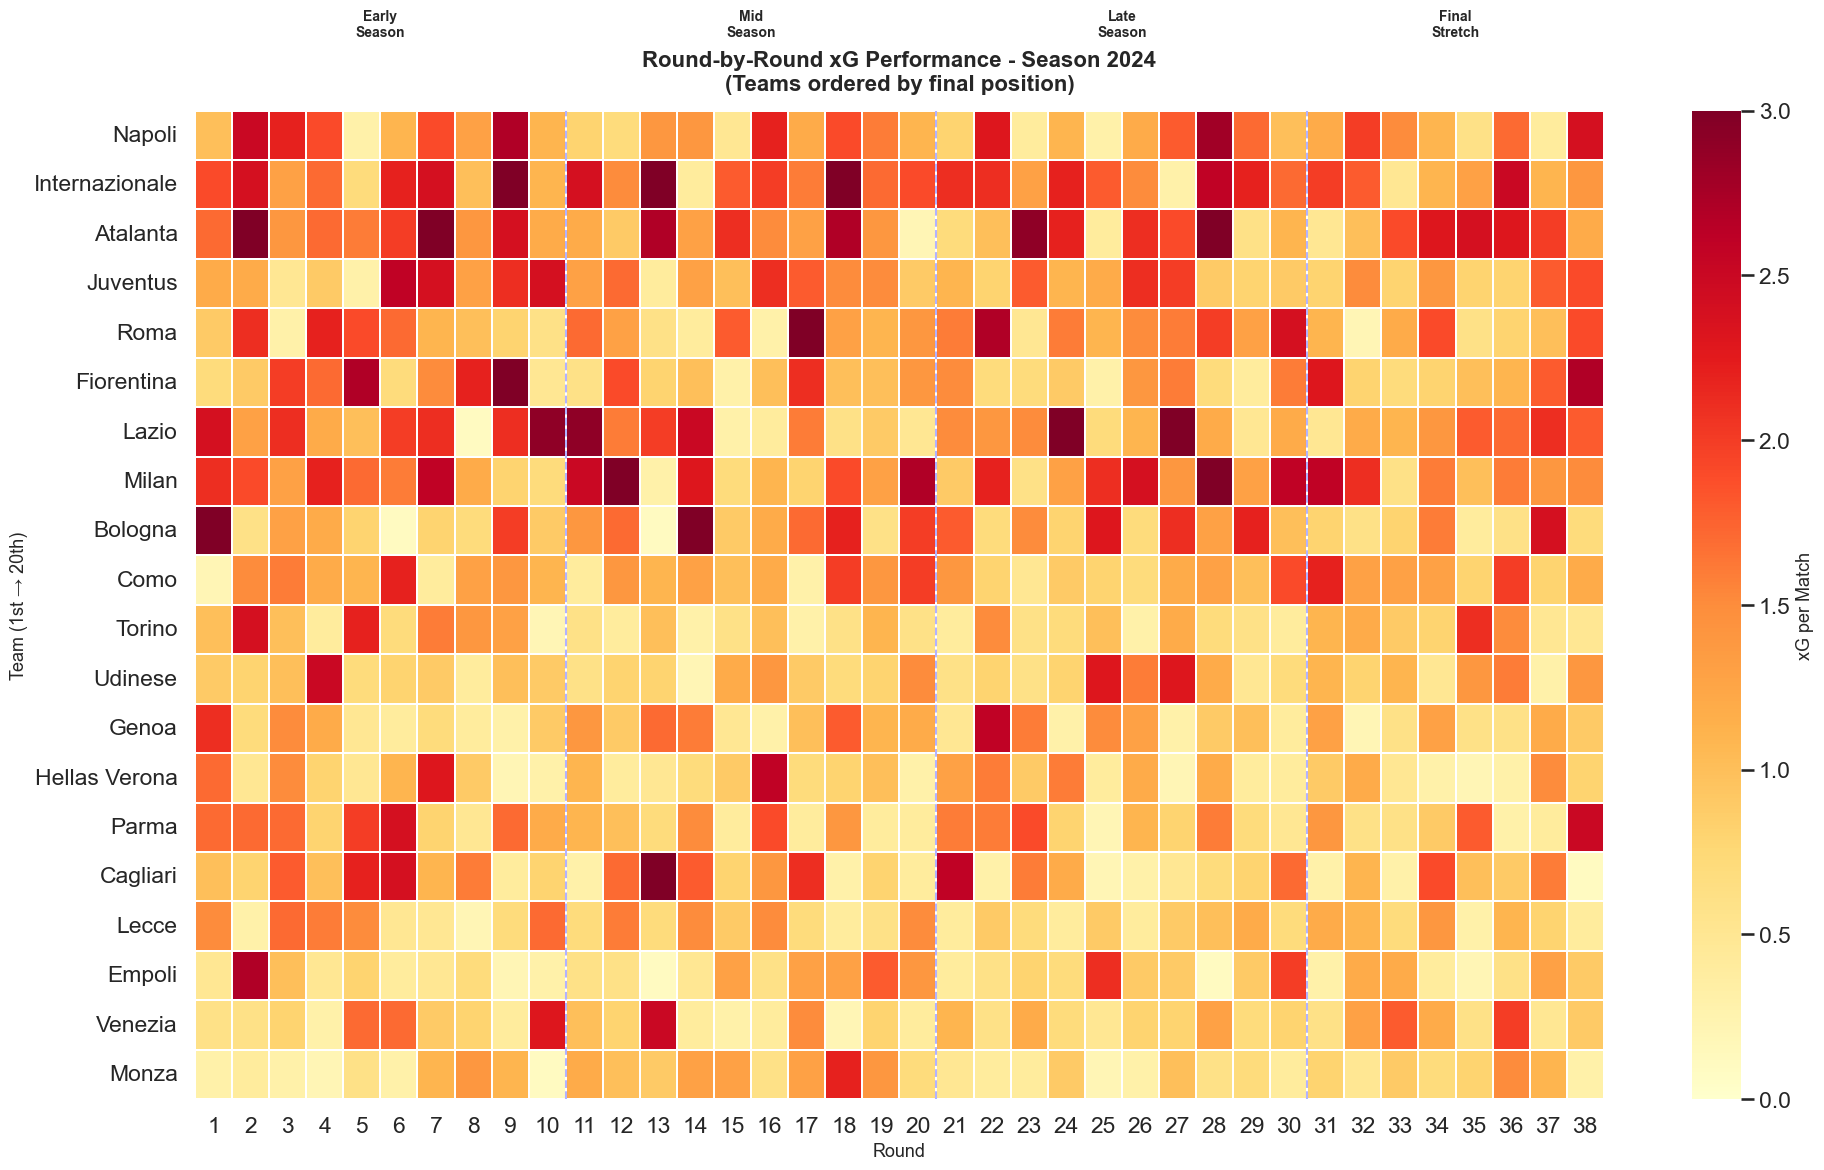


Season 2024 - Performance by Period

Average xG by period:
  Early Season (Rounds 1-10):   1.283
  Mid Season (Rounds 11-20):    1.212
  Late Season (Rounds 21-30):   1.173
  Final Stretch (Rounds 31-38): 1.139

Strongest finishers (best average xG in rounds 31-38):
  Atalanta: 1.700 xG
  Milan: 1.550 xG
  Internazionale: 1.462 xG
  Lazio: 1.450 xG
  Fiorentina: 1.400 xG



In [87]:
# Analysis #3: Round-by-Round Performance Heatmap
# Visualize xG performance across all 38 rounds for the focused season

# Use existing season_tables data which has round-by-round information
# Create a matrix of xG per match by team and round

season_data = df[df['season'] == season_focus].copy()

# Aggregate xG per team per round (home + away)
round_performance = []

for team in season_data['team'].unique():
    team_rounds = {}
    
    # Home matches
    home_matches = season_data[season_data['team'] == team]
    for _, match in home_matches.iterrows():
        team_rounds[match['round']] = team_rounds.get(match['round'], 0) + match['xg']
    
    # Away matches
    away_matches = season_data[season_data['opponent'] == team]
    for _, match in away_matches.iterrows():
        team_rounds[match['round']] = team_rounds.get(match['round'], 0) + match['xga']
    
    # Create row for this team
    for round_num in range(1, 39):
        round_performance.append({
            'team': team,
            'round': round_num,
            'xg': team_rounds.get(round_num, np.nan)
        })

performance_df = pd.DataFrame(round_performance)

# Create pivot table
heatmap_pivot = performance_df.pivot(index='team', columns='round', values='xg')

# Get final standings from season_tables to sort teams
final_standings = season_tables[season_focus][38].sort_values('pos')
team_order = final_standings['team'].tolist()

# Reorder heatmap by final position
heatmap_pivot = heatmap_pivot.reindex(team_order)

# Create heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(heatmap_pivot, 
            cmap='YlOrRd', 
            annot=False, 
            cbar_kws={'label': 'xG per Match'},
            linewidths=0.1,
            vmin=0,
            vmax=3)

plt.title(f'Round-by-Round xG Performance - Season {season_focus}\n(Teams ordered by final position)', 
          fontsize=16, weight='bold', pad=15)
plt.xlabel('Round', fontsize=13)
plt.ylabel('Team (1st → 20th)', fontsize=13)

# Add vertical lines to highlight key periods
plt.axvline(x=10, color='blue', linestyle='--', alpha=0.3, linewidth=1.5)
plt.axvline(x=20, color='blue', linestyle='--', alpha=0.3, linewidth=1.5)
plt.axvline(x=30, color='blue', linestyle='--', alpha=0.3, linewidth=1.5)

# Add text annotations for periods
plt.text(5, -1.5, 'Early\nSeason', ha='center', fontsize=10, weight='bold')
plt.text(15, -1.5, 'Mid\nSeason', ha='center', fontsize=10, weight='bold')
plt.text(25, -1.5, 'Late\nSeason', ha='center', fontsize=10, weight='bold')
plt.text(34, -1.5, 'Final\nStretch', ha='center', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

# Calculate average xG by period
print(f"\n{'='*70}")
print(f"Season {season_focus} - Performance by Period")
print(f"{'='*70}\n")

early = performance_df[performance_df['round'] <= 10]['xg'].mean()
mid = performance_df[(performance_df['round'] > 10) & (performance_df['round'] <= 20)]['xg'].mean()
late = performance_df[(performance_df['round'] > 20) & (performance_df['round'] <= 30)]['xg'].mean()
final = performance_df[performance_df['round'] > 30]['xg'].mean()

print(f"Average xG by period:")
print(f"  Early Season (Rounds 1-10):   {early:.3f}")
print(f"  Mid Season (Rounds 11-20):    {mid:.3f}")
print(f"  Late Season (Rounds 21-30):   {late:.3f}")
print(f"  Final Stretch (Rounds 31-38): {final:.3f}")

# Identify strongest finishers
final_rounds = performance_df[performance_df['round'] > 30]
strong_finishers = final_rounds.groupby('team')['xg'].mean().sort_values(ascending=False).head(5)

print(f"\nStrongest finishers (best average xG in rounds 31-38):")
for team, xg in strong_finishers.items():
    print(f"  {team}: {xg:.3f} xG")

print(f"\n{'='*70}")